 # Vehicle Routing Problem
 VRP with:
 - [x] Pickups and Deliveries Constraints
 - [x] Capacity Constraints
 - [ ] Time Window Constraints
 - [ ] Rescource Constraints
 - [x] Penalties And Dropping Visits

 ## Imports
 Import all the required libraries

In [1]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from matplotlib import pyplot as plt
import numpy as np

FROM_GOOGLE_MAPS = False

if FROM_GOOGLE_MAPS: 
    from distance_matrix_maps import data
else:
    from distance_matrix_manual import data


 ## Prepare the data
 Define model values

In [2]:
locations = np.array(data['locations'])
data['num_vehicles'] = 4
data['depot'] = 0 


 Add pickup-delivery request

In [3]:
data['pickups_deliveries'] = [
    [1, 6],
    [2, 10],
    [4, 3],
    [5, 9],
    [7, 8],
    [15, 11],
    [13, 12],
    [16, 14],
]


 Add capacity request

In [4]:
MIN_LOAD_SIZE = 3
MAX_LOAD_SIZE = 8
data['vehicle_capacities'] = [10] * data['num_vehicles']
data['demands'] = [0] * len(data['locations'])
for (i, j) in data['pickups_deliveries']:
    demand = np.random.randint(MIN_LOAD_SIZE, MAX_LOAD_SIZE + 1)
    data['demands'][i] = demand
    data['demands'][j] = -demand + np.random.randint(MIN_LOAD_SIZE, MAX_LOAD_SIZE + 1)
data['demands']


[0, 4, 8, -1, 8, 8, -1, 6, 2, -3, 0, -1, 0, 5, 3, 7, 3]

 Create the routing index manager.

In [5]:
manager = pywrapcp.RoutingIndexManager(
    len(data['distance_matrix']),
    data['num_vehicles'], 
    data['depot']
)


 ## Visualize the problem

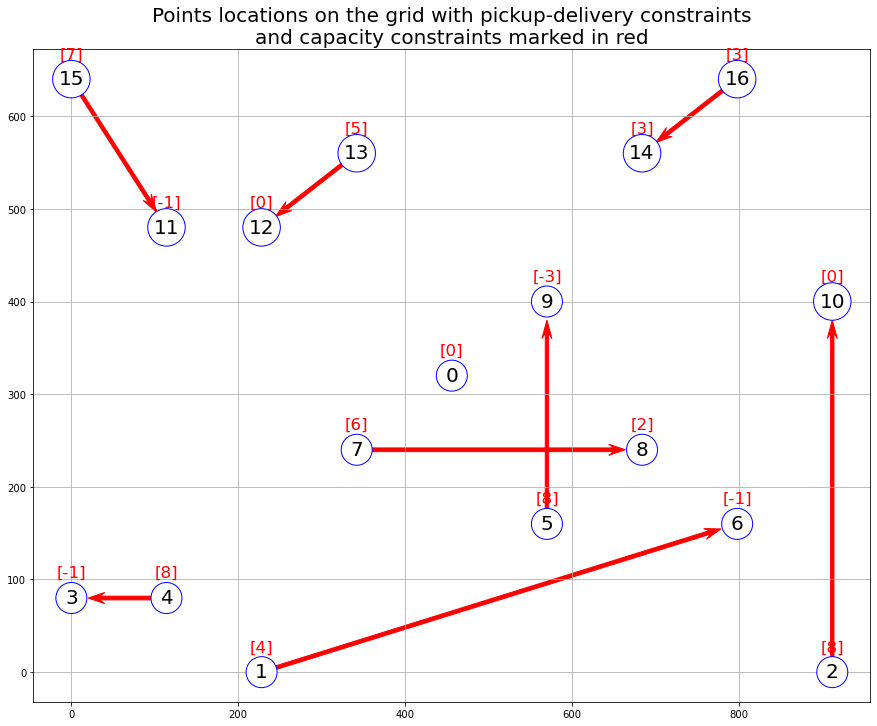

In [6]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(
    x=locations[:, 0],
    y=locations[:, 1],
)
marker_size = 20
for i, loc in enumerate(locations):
    ax.annotate(
        s=f"{i}", 
        xy=loc, 
        xycoords='data',
        va='center',
        ha='center',
        size=marker_size,
        bbox=dict(boxstyle='circle', fc='w', ec='b'))
    ax.annotate(
        s=f"[{data['demands'][i]}]", 
        xy=loc, 
        xytext=(0, marker_size + 5),
        xycoords='data',
        textcoords='offset points',
        va='center',
        ha='center',
        size=marker_size / 1.2,
        color='red')
for pd_request in data['pickups_deliveries']:
    arrow = np.array([
        locations[pd_request[0]], 
        locations[pd_request[1]] - locations[pd_request[0]]
    ])
    arrow_length = np.linalg.norm(arrow[1])
    arrow_scale = (arrow_length - marker_size) / arrow_length
    ax.arrow(
        *arrow[0],
        *(arrow[1] * arrow_scale),
        color='r',
        width=4,
        head_width=12,
        head_length=20,
        overhang=.3,
        length_includes_head=True,
    )
ax.grid(which='both')
ax.set_title('Points locations on the grid with pickup-delivery constraints\nand capacity constraints marked in red', fontsize=20)
plt.show()


 ## Create Routing Model

In [7]:
routing = pywrapcp.RoutingModel(manager)


 ### Create and register a distance transit callback.

In [8]:
def distance_callback(from_index, to_index):
    """
    Returns the distance between the two nodes.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)


 ### Define cost of each arc.

In [9]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


 ### Create and register a capacity demand callback.

In [10]:
def demand_callback(from_index):
    """
    Returns the demand of the node.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)


 ### Add Distance constraint.

In [11]:
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,      # no slack
    3000,   # vehicle maximum travel distance
    True,   # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)


 ### Add Demand constraint.

In [12]:
dimension_name = 'Capacity'
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,                          # no slack
    data['vehicle_capacities'], # vehicle maximum capacities
    True,                       # start cumul to zero
    dimension_name)
demand_dimension = routing.GetDimensionOrDie(dimension_name)


 ### Define Transportation Requests for pickups and deliveries

In [13]:
for request in data['pickups_deliveries']:
    pickup_index = manager.NodeToIndex(request[0])
    delivery_index = manager.NodeToIndex(request[1])
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    routing.solver().Add(
        routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index)
    )
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index)
    )


 ### Allow to drop nodes.

In [14]:
penalty = np.sum(data['distance_matrix']).item()
for node in range(1, len(data['distance_matrix'])):
    routing.AddDisjunction([manager.NodeToIndex(node)], penalty)


 ## Set first solution to heuristic.

In [15]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters


first_solution_strategy: PATH_CHEAPEST_ARC
local_search_operators {
  use_relocate: BOOL_TRUE
  use_relocate_pair: BOOL_TRUE
  use_relocate_neighbors: BOOL_FALSE
  use_exchange: BOOL_TRUE
  use_cross: BOOL_TRUE
  use_cross_exchange: BOOL_FALSE
  use_two_opt: BOOL_TRUE
  use_or_opt: BOOL_TRUE
  use_lin_kernighan: BOOL_TRUE
  use_tsp_opt: BOOL_FALSE
  use_make_active: BOOL_TRUE
  use_make_inactive: BOOL_TRUE
  use_make_chain_inactive: BOOL_FALSE
  use_swap_active: BOOL_TRUE
  use_extended_swap_active: BOOL_FALSE
  use_path_lns: BOOL_FALSE
  use_full_path_lns: BOOL_FALSE
  use_tsp_lns: BOOL_FALSE
  use_inactive_lns: BOOL_FALSE
  use_node_pair_swap_active: BOOL_TRUE
  use_relocate_and_make_active: BOOL_FALSE
  use_exchange_pair: BOOL_TRUE
  use_relocate_expensive_chain: BOOL_TRUE
  use_light_relocate_pair: BOOL_TRUE
  use_relocate_subtrip: BOOL_TRUE
  use_exchange_subtrip: BOOL_TRUE
  use_global_cheapest_insertion_path_lns: BOOL_TRUE
  use_local_cheapest_insertion_path_lns: BOOL_TRUE
  use

 ## Solve the problem.

In [16]:
solution = routing.SolveWithParameters(search_parameters)


 ## Print the solution
 - Display routes
 - Display dropped nodes

In [17]:
dropped_ids = []
if solution:
    # Display routes
    total_distance = 0
    global_max_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        print(f'Route for vehicle {vehicle_id}:')
        route_distance = 0
        max_route_load = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            print(f' {node_index} Load({route_load}) -> ', end='')
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            max_route_load = max(route_load, max_route_load)
        print(f'{manager.IndexToNode(index)} Load({route_load})\n')
        print(f'Distance of the route: {route_distance}m')
        total_distance += route_distance
        print(f'Max load of the route: {route_load}\n-------------')
        global_max_load = max(global_max_load, max_route_load)
    print(f'Total distance of all routes: {total_distance}m')
    print(f'Maximum load for all vehicles: {global_max_load}')
    print('=====================')
    # Display dropped nodes.
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_ids.append(manager.IndexToNode(node))
    print(f'Dropped nodes: {dropped_ids if dropped_ids else None}')
else:
    print('No solution found')


Route for vehicle 0:
 0 Load(0) ->  4 Load(8) ->  3 Load(7) -> 0 Load(7)

Distance of the route: 1392m
Max load of the route: 7
-------------
Route for vehicle 1:
 0 Load(0) ->  1 Load(4) ->  6 Load(3) ->  16 Load(6) ->  14 Load(9) -> 0 Load(9)

Distance of the route: 2420m
Max load of the route: 9
-------------
Route for vehicle 2:
 0 Load(0) ->  5 Load(8) ->  9 Load(5) ->  13 Load(10) ->  12 Load(10) -> 0 Load(10)

Distance of the route: 1484m
Max load of the route: 10
-------------
Route for vehicle 3:
 0 Load(0) ->  7 Load(6) ->  8 Load(8) -> 0 Load(8)

Distance of the route: 844m
Max load of the route: 8
-------------
Total distance of all routes: 6140m
Maximum load for all vehicles: 10
Dropped nodes: [2, 10, 11, 15]


 ## Visualize the solution

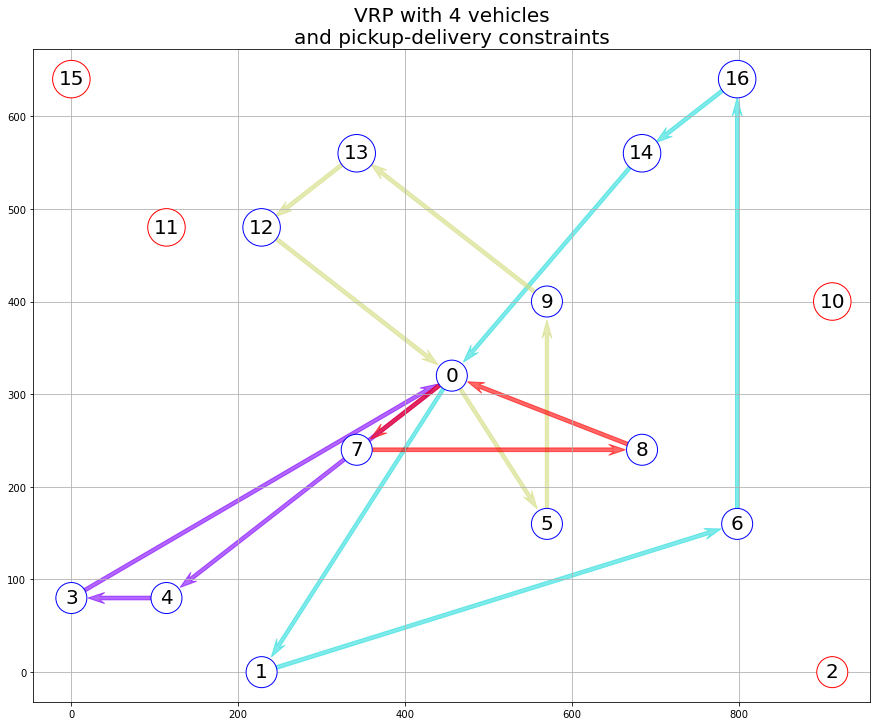

In [18]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(*locations.T)
marker_size = 20
for i, loc in enumerate(locations):
    ax.annotate(
        s=f"{i}", 
        xy=loc, 
        xycoords='data',
        va='center',
        ha='center',
        size=marker_size,
        bbox=dict(
            boxstyle='circle', 
            fc='w', 
            ec='blue' if i not in dropped_ids else 'red'
        )
    )
colors = plt.cm.rainbow(np.linspace(0, 1, data['num_vehicles']))
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    while not routing.IsEnd(index):
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        arrow = np.array([
            locations[manager.IndexToNode(previous_index)], 
            locations[manager.IndexToNode(index)] - locations[manager.IndexToNode(previous_index)]
        ])
        arrow_length = np.linalg.norm(arrow[1])
        arrow_scale = (arrow_length - marker_size) / arrow_length
        ax.arrow(
            *arrow[0],
            *(arrow[1] * arrow_scale),
            color=colors[vehicle_id],
            alpha=.6,
            label=f'Vehicle {vehicle_id}',
            width=4,
            head_width=12,
            head_length=20,
            overhang=.3,
            length_includes_head=True,
        )
ax.grid(which='both')
ax.set_title(f'VRP with {data["num_vehicles"]} vehicles\nand pickup-delivery constraints', fontsize=20)
plt.show()

